# Spotify data analysis: A retrospective

Every December since 2016, Spotify users discover their "Spotify Wrapped". The latter provides a compilation of data about their activity on the platform over the past year: top artists, top songs, top genres, etc. 

My objective here is to reproduce most insights from Spotify Wrapped using Python and SQL programming languages. 

To do so, I downloaded all my Spotify user data from the app in November 2022. 

In [31]:
# Import all relevant Python packages
import glob
import os
import pandas as pd
import numpy as np
import json
import string
import sqlite3
import matplotlib as plt
import seaborn as sns

## 1. Import and prepare the Spotify data (JSON files)

*Objective* : I received my Spotify data in different batches (8 JSON files). My goal is to import all of them at once in a Pandas dataframe, and remove every private information (IP address, device information, etc).  
*Inspiration for the code below* : https://stackoverflow.com/questions/41857659/python-pandas-add-filename-column-csv

### 1.1. Importing the data

In [2]:
# Step 1 : I look for all JSON files available in my Windows folder (where I stored my Spotify data)

path_to_json = 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData/' #local path to my JSON files folder 
json_pattern = os.path.join(path_to_json,'*.json') #looking for every JSON file
globbed_files = glob.glob(json_pattern) #listing all the JSON files paths
globbed_files #overview

['C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_0.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_1.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_2.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_3.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_4.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_5.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endsong_6.json',
 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData\\endvideo.json']

In [3]:
# Step 2: I open and read every JSON file thanks to a for loop. 
   # I also add a column "filename" that contains the name of each file
   # Finally, I store all data in a "data" list

data = [] # empty list (initialization) 
for json in globbed_files:
    frame = pd.read_json(json) 
    frame['filename'] = os.path.basename(json) 
    data.append(frame) 

In [4]:
# Step 3: Export the data to csv format
bigframe = pd.concat(data, ignore_index=True) #dont want pandas to try an align row indexes
bigframe.to_csv("spotify_data.csv", sep = ';')

C:\Users\margo\AppData\Local\Temp\ipykernel_26892\1933132580.py:2: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  bigframe = pd.concat(data, ignore_index=True) #dont want pandas to try an align row indexes


### 1.2. Preparing the data

In [5]:
# Step 4 : Remove private information (username, user agent, device, IP address) 
spotify_data = pd.read_csv("spotify_data.csv", sep = ';', index_col = 0)

# Blur device information
spotify_data["device"] = spotify_data["platform"].str[:10]

# Delete columns that share too much information
to_delete = ['username', 'ip_addr_decrypted', 'user_agent_decrypted', 'platform']
spotify_data.drop(to_delete, axis=1, inplace=True)

In [34]:
# Step 5 : Add variables that will be useful for data analysis
# Time variables
spotify_data['year'] = pd.to_datetime(spotify_data['ts']).dt.strftime('%Y')
spotify_data['year_month'] = pd.to_datetime(spotify_data['ts']).dt.strftime('%Y-%m')
spotify_data['month'] = pd.to_datetime(spotify_data['ts']).dt.strftime('%m')
spotify_data["date"] = pd.to_datetime(spotify_data["ts"]).dt.strftime('%Y-%m-%d')
spotify_data["hour"] = pd.to_datetime(spotify_data["ts"]).dt.strftime('%H')

# Durations
spotify_data["sec_played"] = round(spotify_data["ms_played"]/1000,4) #Convert milliseconds to seconds
spotify_data["min_played"] = round(spotify_data["ms_played"]/1000/60,2) #Convert milliseconds to minutes

# Music vs podcast
spotify_data["type"] = np.where(~spotify_data["spotify_track_uri"].isnull(), "Music", 
                                np.where(~spotify_data["spotify_episode_uri"].isnull(), "Podcast", "Error")
                               )

In [35]:
# Step 6: Rename some variables whose names are unclear and/or too long
spotify_data = spotify_data.rename(columns = {'master_metadata_track_name' : 'track_name',
                                   'master_metadata_album_artist_name' : 'artist_name',
                                   'master_metadata_album_album_name' : 'album_name'
                                             })

#End results
pd.set_option('display.max_columns', None)
spotify_data.sort_values('ts', ascending = False).head(5)

,ts,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,filename,device,year,year_month,month,date,hour,sec_played,min_played,type
61375,2022-11-24T22:42:26Z,788584,FR,NaN,NaN,NaN,NaN,Journal 07h00 du mardi 22 novembre 2022,Journal de 07h00,spotify:episode:4Adwt7pETOXPNplhooHLa1,clickrow,endplay,False,NaN,0.0,1.669328e+12,False,endsong_3.json,Android OS,2022,2022-11,11,2022-11-24,22,788.584,13.14,Podcast
88700,2022-11-24T22:18:34Z,155703,FR,Dancing With The Devil,ISBANKY,Dancing With The Devil,spotify:track:0ChUbF2A6VjPVRFOKJ8VSN,NaN,NaN,NaN,trackdone,logout,False,NaN,0.0,1.669325e+12,False,endsong_5.json,Android OS,2022,2022-11,11,2022-11-24,22,155.703,2.60,Music
36788,2022-11-24T21:29:29Z,123750,FR,Pharaoh's Wrath,Feerix,Pharaoh's Wrath,spotify:track:1XQQwnbfGqezphAHjaVxXR,NaN,NaN,NaN,trackdone,trackdone,False,NaN,0.0,1.669325e+12,False,endsong_2.json,Android OS,2022,2022-11,11,2022-11-24,21,123.750,2.06,Music
7564,2022-11-24T21:27:24Z,187306,FR,Ma solitude,Kendji Girac,Ensemble,spotify:track:2lZW1J1ScVcV8qHMkHN64u,NaN,NaN,NaN,clickrow,trackdone,False,NaN,0.0,1.669325e+12,False,endsong_0.json,Android OS,2022,2022-11,11,2022-11-24,21,187.306,3.12,Music
89308,2022-11-24T21:24:18Z,17268,FR,Poison Love,Dreamcatcher,[Dystopia : Road to Utopia],spotify:track:7C3cUybMDDF7PKyFcDWouF,NaN,NaN,NaN,trackdone,endplay,False,NaN,0.0,1.669325e+12,False,endsong_5.json,Android OS,2022,2022-11,11,2022-11-24,21,17.268,0.29,Music


## 2. Set up the SQL connection

*Objective* : The spotify_data dataframe will be analyzed thanks to SQL queries. The goal is indeed to mimick data analysis in a Datawharehouse like Teradata or Google Big Query. To do so, I must create a SQL connection beforehand.

In [36]:
# Create the SQLITE3 connection
cnx = sqlite3.connect(':memory:')

# Transform the Pandas dataframe "spotify_data" to a SQL table "spotify"
spotify_data.to_sql(name='spotify', con=cnx)

97998

## 3. Understand the dataset

*Objective*: I perform some simple exploratory data analyses to better understand the dataset I retrieved in the previous steps. The goal is to answer some simple questions:
* What is the total volumetry? How is it distributed per JSON file and year ?
* What is the period considered (min and max dates) ?
* Are there problems (NULLs, duplicates, etc) ?

In [9]:
# Total volumetry: About 100k rows in total
volumetry = pd.read_sql('''SELECT COUNT(*) AS nb_rows 
                        FROM spotify''', cnx)
volumetry

,nb_rows
0,97998


In [10]:
# Volumetry per file: 
    # Every JSON file contains about 15,800 rows (except the video and last endsong files)
    # The data span from February 2020 to end November 2022
    # Each file contains about the same proportion of music tracks (98%) / podcasts episodes (2%) 
    # - except the endvideo file that contains only video podcasts
volumetry_file = pd.read_sql('''SELECT filename, 
                                 MIN(date) AS min_date,
                                 MAX(date) AS max_date,
                                 COUNT(*) AS nb_rows,
                                 SUM(CASE WHEN track_name IS NOT NULL THEN 1 ELSE 0 END) AS music_tracks,
                                 SUM(CASE WHEN episode_name IS NOT NULL THEN 1 ELSE 0 END) AS podcast_eps,
                                 ROUND(CAST(SUM(CASE WHEN track_name IS NOT NULL THEN 1 ELSE 0 END) AS FLOAT)
                                   / CAST(COUNT(*) AS FLOAT),2) AS pct_music_tracks,
                                 ROUND(CAST(SUM(CASE WHEN episode_name IS NOT NULL THEN 1 ELSE 0 END) AS FLOAT) /
                                 CAST(COUNT(*) AS FLOAT), 2) AS pct_podcast
                             FROM spotify
                             GROUP BY 1''', cnx)

volumetry_file

,filename,min_date,max_date,nb_rows,music_tracks,podcast_eps,pct_music_tracks,pct_podcast
0,endsong_0.json,2020-02-02,2022-11-24,15851,15485,357,0.98,0.02
1,endsong_1.json,2020-02-02,2022-11-24,15855,15510,332,0.98,0.02
2,endsong_2.json,2020-02-02,2022-11-24,15849,15509,322,0.98,0.02
3,endsong_3.json,2020-02-02,2022-11-24,15838,15507,317,0.98,0.02
4,endsong_4.json,2020-02-02,2022-11-24,15834,15504,320,0.98,0.02
5,endsong_5.json,2020-02-02,2022-11-24,15833,15472,351,0.98,0.02
6,endsong_6.json,2020-02-03,2022-11-24,2900,2849,51,0.98,0.02
7,endvideo.json,2021-07-30,2022-11-22,38,0,38,0.00,1.00


## 4. Data analysis

### 4.1 Spotify yearly consumption

*Objective* : I want to understand whether my Spotify listening habits have changed over time. To do so, I want to answer the following questions:
* Do I use more and more Spotify services over time? (number of sessions and hours played)
* Am I versatile or do I tend to listen to the same artists / songs over time? (number of distinct artists and tracks)
* What is the breakdown of my consumption between music tracks and podcasts?

#### 4.1.1 Summary statistics

In [11]:
## 4.1. Listening habits (volumes)
    # I compute for each year the number of listening sessions I had, 
    # as well as the number of different tracks and artists I listened to.
    # I do the same for podcasts : number of different shows and episodes I listened to.
listening_year = \
    pd.read_sql('''
             SELECT year, 
                   COUNT(*) AS nb_sessions,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day,
                   ROUND(CAST(COUNT(*) AS FLOAT) / CAST(COUNT(DISTINCT spotify_track_uri) AS FLOAT),2) AS sessions_music_track,
                   COUNT(DISTINCT artist_name) AS artists, 
                   COUNT(DISTINCT spotify_track_uri) AS music_tracks,
                   COUNT(DISTINCT episode_show_name) AS podcast_shows,
                   COUNT(DISTINCT spotify_episode_uri) AS podcast_episodes
               FROM spotify
               GROUP BY year
               ORDER BY year DESC''', cnx)
listening_year

,year,nb_sessions,hours_played,hours_played_day,sessions_music_track,artists,music_tracks,podcast_shows,podcast_episodes
0,2022,44371,1979.210000,6.03,9.06,1465,4896,44,916
1,2021,33696,1779.943667,4.90,12.75,782,2643,37,622
2,2020,19931,957.428000,3.42,7.58,693,2628,13,45


In [12]:
## 4.1. Listening habits (YoY percentage change)
    # I compute the percentage change year on year for each metric
listening_year_pct = \
    pd.read_sql('''
             SELECT year, 
                 ROUND(CAST(nb_sessions AS FLOAT) / 
                       CAST(LAG(nb_sessions) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_nb_sessions,
                 ROUND(CAST(hours_played AS FLOAT) / 
                       CAST(LAG(hours_played) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_hours,
                 ROUND(CAST(hours_played_day AS FLOAT) / 
                       CAST(LAG(hours_played_day) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_hours_day,
                 ROUND(CAST(sessions_music_track AS FLOAT) / 
                       CAST(LAG(sessions_music_track) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_sessions_music_track,
                 ROUND(CAST(artists AS FLOAT) / 
                       CAST(LAG(artists) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_artists, 
                 ROUND(CAST(music_tracks AS FLOAT) / 
                       CAST(LAG(music_tracks) OVER (ORDER BY year) AS FLOAT),2) -1 AS pct_music_tracks,
                 ROUND(CAST(podcasts AS FLOAT) / 
                       CAST(LAG(podcasts) OVER (ORDER BY year) AS FLOAT), 2) -1 AS pct_podcasts, 
                 ROUND(CAST(podcast_shows AS FLOAT) / 
                       CAST(LAG(podcast_shows) OVER (ORDER BY year) AS FLOAT), 2) -1 AS pct_podcast_shows

             FROM (
             SELECT year, 
                   COUNT(*) AS nb_sessions,
                   COUNT(*) / COUNT(DISTINCT date) AS nb_sessions_day,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day,
                   CAST(COUNT(*) AS FLOAT) / CAST(COUNT(DISTINCT spotify_track_uri) AS FLOAT) AS sessions_music_track,
                   COUNT(DISTINCT artist_name) AS artists, 
                   COUNT(DISTINCT spotify_track_uri) AS music_tracks,
                   COUNT(DISTINCT spotify_episode_uri) AS podcasts,
                   COUNT(DISTINCT episode_show_name) AS podcast_shows
               FROM spotify
               GROUP BY year
               ORDER BY year DESC
             ) subquery
             ORDER BY year DESC''', cnx)
listening_year_pct

,year,pct_nb_sessions,pct_hours,pct_hours_day,pct_sessions_music_track,pct_artists,pct_music_tracks,pct_podcasts,pct_podcast_shows
0,2022,0.32,0.11,0.23,-0.29,0.87,0.85,0.47,0.19
1,2021,0.69,0.86,0.43,0.68,0.13,0.01,12.82,1.85
2,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
<b>Learnings:</b> <b>Between 2020 and 2022, I more than doubled my total number of listening sessions (i.e. 19,931 to 44,371 sessions). This increase is also reflected by the total number of hours played (957 hours to 1979 hours, i.e. 3.4 hours/day to 6 hours/day).</b> To understand why, it is useful to decompose the evolution in 2 parts. <br>
<br>
Between 2020 and 2021, my total number of sessions increased by 69%. This jump is to be explained by 2 main factors. First, as far as music is concerned, I listened to the same number of songs (ca 2,600 tracks) but <em>each song was played more frequently</em> (12.7 times instead of 7.5 times). Regarding <em>podcasts</em>, my consumption surged: I almost trippled my number of podcasts, and listened to far more episodes (namely 45 to 622 episodes, i.e. +1280%). 
<br>
<br>
Between 2021 and 2022, my total number of sessions increased further by 32% (although 2022 is not a complete year in the dataset). I continued listening to more podcasts. But first and foremost, I started listening to more <em>music playlists</em> that enabled me to discover new artists and new tracks. That way, in 2022, I listened to  1400+ different artists (against 700 on average in the previous years). I also listened to 4800 different music tracks (instead of 2600 before). I am thus far more versatile and curious. Still, on average, I tended to listen to the same song 9 times, which is higher than in 2020 (8 times).

#### 4.1.2. Graphs

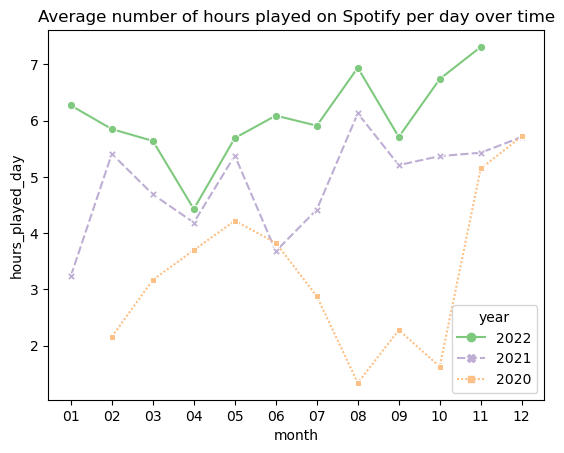

In [39]:
# Monthly evolution
listening_monthyear = \
    pd.read_sql('''
             SELECT year, month,
                   COUNT(*) AS nb_sessions,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day
               FROM spotify
               GROUP BY 1,2
               ORDER BY 1 DESC, 2''', cnx)
listening_monthyear

g = sns.lineplot(data = listening_monthyear, 
                 x= 'month', y = 'hours_played_day', 
                 hue = 'year', palette = 'Accent', style = 'year', markers = True).\
    set(title = 'Average number of hours played on Spotify per day over time')

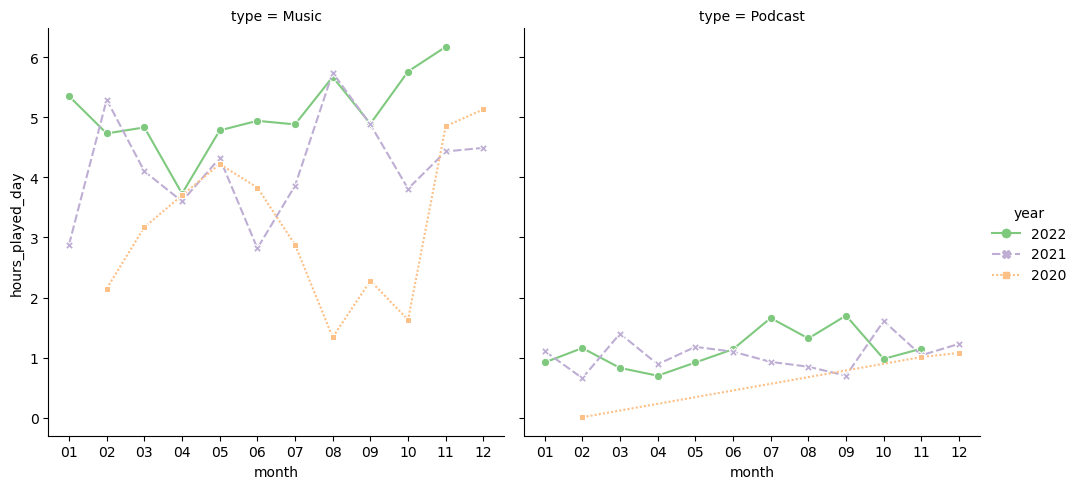

In [38]:
# Monthly evolution, by type of media
listening_monthyear = \
    pd.read_sql('''
             SELECT year, month, type,
                   COUNT(*) AS nb_sessions,
                   SUM(min_played)/60 AS hours_played,
                   ROUND(SUM(min_played)/60/COUNT(DISTINCT date),2) AS hours_played_day
               FROM spotify
               WHERE type <> 'Error'
               GROUP BY 1,2,3
               ORDER BY 1 DESC, 2, 3''', cnx)
listening_monthyear

g = sns.relplot(data = listening_monthyear, 
                 x= 'month', y = 'hours_played_day', col = "type", kind = "line",
                 hue = 'year', palette = 'Accent', style = 'year', markers = True)

<div class="alert alert-block alert-info">
<b>Learnings:</b> <b>I started using Spotify in February 2020, just before the first French Covid19 lockdown was implemented.</b> During the lockdown, I used the service about 4 hours a day, and then almost completely stopped using it during the summer 2020 (end of the 1st lockdown). However, at the end of 2020, a second lockdown took place in France: I resumed using Spotify (up to 5 / 6 hours a day). After that, I never stopped using the app. 
<br><br>
    <b>My podcast consumption was almost non existent in 2020 (only 3 data points in the graph).</b> In 2021 and 2022, I listened to podcasts about 1 hour a day, whatever the month considered. My music consumption is however much more time variant (for instance, summers 2020 and 2021 are complete opposites).
<br> 

## 4.2. Listening habits

*Objective*: I want to find out...
* Time: When do I listen mostly Spotify? In public transports, at work, at home ? 
* Device: Which device do I use most?

In [ ]:
# Draw a nested barplot by species and sex
sns.countplot(
    data=spotify_data, x="year", hue = "device", palette = "Accent"
)

In [ ]:
# Time: When do I listen mostly Spotify? In public transports, at work, at home ?
# Par année, par heure, combien de morceaux de musique écoutés ? combien de podcasts écoutés ?
hour_played = pd.read_sql( 
    '''
    SELECT 
        time_day, hour, nb_music_tracks, nb_podcasts_ep, offline,
        ROUND(CAST(offline AS FLOAT) / (nb_music_tracks + nb_podcasts_ep) ,2) AS pct_offline,
        ROUND(CAST(nb_music_tracks AS FLOAT) / CAST(SUM(nb_music_tracks) OVER () AS FLOAT), 2) AS pct_music_tracks,
        ROUND(CAST(nb_podcasts_ep AS FLOAT) / CAST(SUM(nb_podcasts_ep) OVER () AS FLOAT), 2) AS pct_podcasts,
        ROUND(CAST(SUM(nb_music_tracks) OVER (PARTITION By time_day) AS FLOAT) / CAST(SUM(nb_music_tracks) OVER () AS FLOAT), 2) AS pct_music_time_day,
        ROUND(CAST(SUM(nb_podcasts_ep) OVER (PARTITION By time_day) AS FLOAT) / CAST(SUM(nb_podcasts_ep) OVER () AS FLOAT), 2) AS pct_podcast_time_day
    FROM (
    SELECT 
        CASE 
            WHEN CAST(hour AS INT) BETWEEN 0 AND 7 OR CAST(hour AS INT)>=23 THEN 'NIGHT'
            WHEN CAST(hour AS INT) BETWEEN 8 AND 12 THEN 'MORNING'
            WHEN CAST(hour AS INT) BETWEEN 13 AND 18 THEN 'AFTERNOON'
            WHEN CAST(hour AS INT) BETWEEN 19 AND 22 THEN 'EVENING'
        END AS time_day, 
        hour,
        COUNT(spotify_track_uri) AS nb_music_tracks,
        COUNT(spotify_episode_uri) AS nb_podcasts_ep,
        SUM(offline) AS offline
    FROM spotify 
    GROUP BY 1,2
    ORDER BY 2,1
    ) subquery
    ORDER BY hour, time_day'''
    , cnx)
hour_played

In [ ]:
sns.lineplot(data = hour_played, x= 'hour', y = 'nb_music_tracks', color = '#0208b3')\
    .set(title = "Total number of music tracks listened by hour (2020-2022)") 

In [ ]:
sns.lineplot(data = hour_played, x= 'hour', y = 'nb_podcasts_ep', color = '#0208b3') \
    .set(title = "Total number of podcast episodes listened by hour (2020-2022)") 

<div class="alert alert-block alert-info">
<b>Learnings:</b> <b>When I listen to music, it is mostly in the morning (31%) and afternoon (40%), whatever the hour. </b>
<br><br>    
    <b>On the contrary, I listen mostly to podcasts in the evening (47%) and at night (44%).</b> 9PM and 10PM are the 2 hours I listen mostly to podcasts (respectively 21% and 18%), i.e. usually before going to sleep. It happens that I turn on podcasts when I wake up for some reason in the early morning (around 5AM). It usually helps me going back to sleep.


In [ ]:
# Time: When do I listen mostly Spotify? In public transports, at work, at home ?
hour_played = pd.read_sql( 
    '''
    SELECT 
        subquery.*,
        ROUND(CAST(nb_music_tracks AS FLOAT) / CAST(SUM(nb_music_tracks) OVER () AS FLOAT), 2) AS pct_music_tracks,
        ROUND(CAST(nb_podcasts_ep AS FLOAT) / CAST(SUM(nb_podcasts_ep) OVER () AS FLOAT), 2) AS pct_podcasts
    FROM (
    
    SELECT 
        CASE 
            WHEN CAST(hour AS INT) BETWEEN 0 AND 7 THEN 'NIGHT'
            WHEN CAST(hour AS INT) BETWEEN 8 AND 12 THEN 'MORNING'
            WHEN CAST(hour AS INT) BETWEEN 13 AND 18 THEN 'AFTERNOON'
            WHEN CAST(hour AS INT) BETWEEN 19 AND 24 THEN 'EVENING'
        END AS time_day, 
        device,
        COUNT(spotify_track_uri) AS nb_music_tracks,
        COUNT(spotify_episode_uri) AS nb_podcasts_ep
    FROM spotify 
    GROUP BY 1,2
    ORDER BY hour
    ) subquery'''
    , cnx)
hour_played

<div class="alert alert-block alert-info">
<b>Learnings:</b> I tend to listen to podcasts only via the Spotify app on my smartphone. Indeed, I usually listen to podcasts while going to bed. As far as music is concerned, I use my phone during the evening and night. During the morning and afternoon, it is mixed between my smartphone and a computer (mine or that of work).
<br>
<br>


## 4.3. Favorite tracks

*Objective*: I want to identify the top music tracks I listened every year. I also want to know whether my top ranking stays the same year over year.

In [ ]:
top_10_music = pd.read_sql('''
            SELECT 
                subquery.*,
                COUNT(*) OVER (PARTITION BY spotify_track_uri) AS song_appearance,
                COUNT(*) OVER (PARTITION BY artist_name) AS artist_appearance
            FROM (
                -- I compute the rank (and allow the possibility of ex aequos)
                SELECT sessions.*,
                    DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                
                FROM ( 
                -- For each year, I compute the total number of sessions for each music track
                    SELECT 
                         year, 
                         spotify_track_uri, 
                         track_name, 
                         artist_name, 
                         COUNT(*) AS nb_sessions
                    FROM spotify
                    WHERE track_name IS NOT NULL
                    GROUP BY 1,2,3,4
                    ORDER BY year ASC, nb_sessions DESC
                    ) sessions
                ) subquery
                WHERE ranking <= 10 
                ORDER BY year ASC, nb_sessions DESC''', cnx)
top_10_music

<div class="alert alert-block alert-info">
    <b>Learning:</b> <b> My top 10 tracks are mostly made of Kpop songs every year. Still, these songs do not last in the top rankings:</b> no song is found in the top 10 for several years. <br>
<br>
<b>However, some artists appear quite consistently in my top 10 songs (e.g. Wonho appears 4 times, K/DA 3 times and Dreamcatcher twice). More surprisingly, my top Kpop songs are not necessarily sung by the most famous Kpop artists (cf. no BTS or Blackpink).</b> It seems that I fell in love of specific songs produced by smaller artists. <br>
<br>
<b>Some titles in the top 10 may be misleading. Indeed, even if some songs do not belong to the Kpop genre, I discovered these songs through Kpop dance. </b>For instance, I discovered Post Malone' 'Motley Crew' song (2nd most listened song in 2021) thanks to the Hyunjin's dance cover on Studio Choom. I fell in love with BewhY's 'Side by Side' song (3nd most listened song in 2021) because of Netflix 1M dance cover. Finally, regarding K/DA, I do not play League of Legends but I really like the MVs featuring famous girl K-rappers.

## 4.3 Favorite artists

*Objective*: I want to identify the top artists I listened to every year. I also want to know whether my top ranking stays the same year over year.

In [ ]:
top_10_artists = pd.read_sql('''
            SELECT 
                year, ranking, artist_name, nb_sessions, nb_artist_tracks, nb_sessions / nb_artist_tracks AS avg_session_track,
                COUNT(*) OVER (PARTITION BY artist_name) AS artist_appearance
            FROM (
                -- I compute the rank (and allow the possibility of ex aequos)
                SELECT sessions.*,
                    DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                
                FROM ( 
                -- For each year, I compute the total number of sessions for each artist
                    SELECT 
                         year, 
                         artist_name, 
                         COUNT(DISTINCT spotify_track_uri) AS nb_artist_tracks,
                         COUNT(*) AS nb_sessions
                    FROM spotify
                    WHERE track_name IS NOT NULL
                    GROUP BY 1,2
                    ORDER BY year ASC, nb_sessions DESC
                    ) sessions
                ) subquery
                WHERE ranking <= 10 
                ORDER BY year ASC, nb_sessions DESC''', cnx)
top_10_artists

<div class="alert alert-block alert-info">
    <b>Learning:</b> <b> My top 10 artists differ quite a lot from the artists available in my top 10 songs ranking.  </b><br>
<br>
<b>First, very famous Kpop groups like BTS, TWICE, Stray Kids or EXO are in the top artists ranking (which was not the case in the top 10 songs ranking).</b> Indeed, for these artists, I tended to listen their whole albums - instead of repeting the same song over and over again. For instance, in 2020, I listened to 94 BTS songs, with an average of 8 plays per song. The same year, I listened to only 5 K/DA songs, with an average of 44 plays per song. That is why K/DA is my top 10 songs in 2020, and not BTS - although BTS is my 2nd most popular artist in 2020.
<br>
<br>    
<b>One thing to notice in 2022 is that there are less Kpop artists in top 10.</b>There are some artists in the 'epic' genre like 2WEI and Two Steps from Hell, as well as some popular western artists like Tiësto and David Guetta. I believe it is because I am listening to more playlists on Spotify that made me discover new songs outside my Kpop comfort zone.
<br>


In [ ]:
top_10_music = pd.read_sql('''
SELECT * FROM (
                SELECT subquery.*,
                    DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                
                FROM ( 
                -- For each year, I compute the total number of sessions for each music track
                    SELECT 
                         year, 
                         spotify_track_uri, 
                         track_name, 
                         artist_name, 
                         COUNT(*) AS nb_sessions,
                         DENSE_RANK() OVER (PARTITION BY year ORDER BY nb_sessions DESC) AS ranking
                    FROM spotify
                    WHERE track_name IS NOT NULL
                    GROUP BY 1,2,3,4
                    ORDER BY year ASC, nb_sessions DESC
                    ) subquery
                    
                    ORDER BY year ASC, nb_sessions DESC''', cnx)
top_10_music

In [ ]:
# Est-ce que j'ai des chansons qui apparaissent plusieurs fois

In [ ]:
Attention ! Les chiffres ne sont pas complets -> à rapporter au mois ou à la journée !!</div>
Rajouter une illustration de l'issue tree : Number sessions -> Music et -> Podcasts. 
Chacun est expliqué par number of tracks et nombre de sessions par tracks. 


Questions : 
   * Quels genres de musique ? -> essayer de récupérer l'info d'une source externe
    * Durée de mes morceaux populaires : de plus en plus courts ?
    * Est-ce que je "zappe" beaucoup ? 
    * Quand sont sortis les morceaux populaires ? -> Est-ce que j'écoute de la musique new ou bien je commence à être nostalgique de vieux morceaux ?
    * Qu'en est-il des podcasts ? -> Je les écoute avant de m'endormir ?
    * Combien de podcasts par jour ?
    * Est-ce que j'utilise beaucoup certaines features de Spotify : mode incognito, mode hors ligne, ... ?

In [ ]:
Questions : 
    * Volume: How many tracks I am usually listening per day? Do I tend to listen to the whole song or am I zapping a lot?
    * Frequency: Am I a monthly / daily active Spotify user?
    * Combien d'artistes / chansons écoutés par an ? Et quelle évolution (cf. playlists : j'en écoutais pas avant -> normalement, j'écoute de plus en plus d'artistes différents)
    * Quels genres de musique ? -> essayer de récupérer l'info d'une source externe
    * Combien de morceaux écoutés par jour ?
    * Temps moyen d'écoute par jour ?
    * Durée de mes morceaux populaires : de plus en plus courts ?
    * Est-ce que je suis maniaque d'un artiste -> j'écoute tout de lui ou alors j'aime seulement un seul morceau de l'artiste à mort ?
    * Est-ce que je "zappe" beaucoup ? 
    * Suis-je une utilisatrice active : jours consécutifs d'écoute dans le mois / la semaine ?
    * Quand j'écoute la musique : matin, midi, soir ? -> transports en commun, travail, week-end ?
    * Quels sont mes tops 10 artistes ? Comment ont-ils évolué ? -> toujours les mêmes ou pas ?
    * Même question pour mes meilleures chansons : ça bouge ou pas ? Quelles sont leurs caractéristiques : même artiste, même genre, même durée,... ?
    * Quand sont sortis les morceaux populaires ? -> Est-ce que j'écoute de la musique new ou bien je commence à être nostalgique de vieux morceaux ?
    * Qu'en est-il des podcasts ? -> Je les écoute avant de m'endormir ?
    * Combien de podcasts par jour ?
    * Est-ce que j'utilise beaucoup certaines features de Spotify : mode incognito, mode hors ligne, ... ?

In [ ]:
# Step 2 : SQL connection
import sqlite3

# Set up SQL connexion
sql_connect = sqlite3.connect('spotify_data.db')

# To execute some SQL command
cursor = sql_connect.cursor()

# Create database
#cursor.execute('''CREATE TABLE spotify_data (
 #   ts timestamp,
  #  username text)''') 

#cursor.execute("INSERT INTO spotify_data VALUES ('2022-07-17T06:07:42Z', 'v7x27nfjb2dri60b7jzl159rl')")

cursor.execute("SELECT * FROM spotify_data;")
print(cursor.fetchone())

sql_connect.commit()

sql_connect.close()

In [ ]:
# Test 2 : Je récupère la liste des fichiers JSON dans mon dossier
import os, json
import pandas as pd

path_to_json = 'C:/Users/margo/Documents/Documents/Formation/Github/Spotify/MyData/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files) 

# Puis j'essaie d'importer chaque file une par une 
for file in json_files :
    df = pd.read_json(path_to_json + file)
    
df

In [ ]:
spotify_data = pd.DataFrame(columns=['ts', 'username', 'platform',
                                    'ms_played', 'conn_country', 'user_agent_decrypted',
                                     'master_metadata_track_name',
                                     'master_metadata_album_artist_name',
                                     'master_metadata_album_album_name',
                                     'spotify_track_uri',
                                     'episode_name',
                                     'episode_show_name',
                                     'spotify_episode_uri',
                                     'reason_start',
                                     'reason_end',
                                     'shuffle', 'skipped', 'offline', 'offline_timestamp'
                                    ])
spotify_data.head(5)
#print spotify_json['features'][0]['geometry']